# Imports

In [4]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap 
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from lightgbmlss.model import *
from lightgbmlss.distributions.Expectile import Expectile
from lightgbmlss.datasets.data_loader import load_simulated_data

# Data

In [5]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = lgb.Dataset(X_train, label=y_train)

# Expectile Specification

In [6]:
distribution = Expectile  
distribution.expectiles = [0.05, 0.95]     # Expectiles to be estimated: needs to be a list of at least two expectiles.
distribution.stabilize = "None"            # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2".

# Hyper-Parameter Optimization

In [4]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
params = {"boosting": "gbdt",
          "eta": [1e-5, 1], 
          "max_depth": [1, 10],
          "num_leaves": [255, 255],           # set to default value for this example
          "min_data_in_leaf": [20, 20],       # set to default value for this example
          "lambda_l1": [0, 0],                # set to default value for this example
          "lambda_l2": [0, 0],                # set to default value for this example
          "min_gain_to_split": [1e-8 , 40],
          "min_sum_hessian_in_leaf":[1, 500],
          "subsample": [0.2, 1.0],
          "feature_fraction": [0.2, 1.0]
         }

opt_params = lightgbmlss.hyper_opt(params,
                                   dtrain=dtrain,
                                   dist=distribution,
                                   num_boost_round=500,       # Number of boosting iterations.
                                   max_minutes=10,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                                   n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                   silence=True)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\lightgbmlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


0it [00:00, ?it/s]

Hyper-Parameter Optimization successfully finished.
Number of finished trials:  322
Best trial:
  Value: 942.3536375590908
  Params: 
    eta: 0.20770465143481498
    max_depth: 3
    num_leaves: 255
    min_data_in_leaf: 20
    lambda_l1: 0
    lambda_l2: 0
    min_gain_to_split: 0.00038427466618099566
    min_sum_hessian_in_leaf: 385
    subsample: 0.8915024106904411
    feature_fraction: 0.7037856072958981
    opt_rounds: 20


# Model Training

In [8]:
np.random.seed(123)

n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
lightgbmlss_model = lightgbmlss.train(opt_params,
                                     dtrain,
                                     dist=distribution,
                                     num_boost_round=n_rounds)

# Prediction

In [12]:
# Extract predicted expectiles
pred_expectile = lightgbmlss.predict(lightgbmlss_model, 
                                     dtest=X_test, 
                                     dist=distribution,
                                     pred_type="expectiles")

In [13]:
pred_expectile.head()

,expectile_0.05,expectile_0.95
0,6.875965,13.274624
1,6.932908,13.210208
2,8.932212,11.179057
3,4.089187,14.871237
4,6.594674,13.467719


# SHAP Interpretability

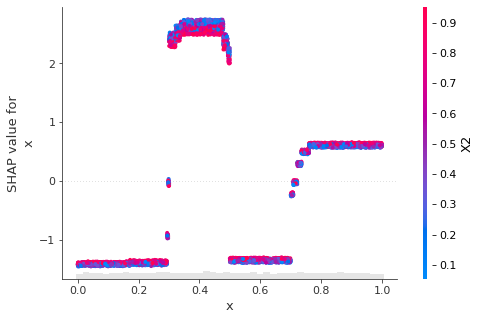

In [14]:
# Partial Dependence Plot of how x acts on selected expectile 
lightgbmlss.expectile_plot(lightgbmlss_model, 
                           X_train, 
                           dist=distribution,
                           expectile="0.95",
                           feature="x", 
                           plot_type="Partial_Dependence")

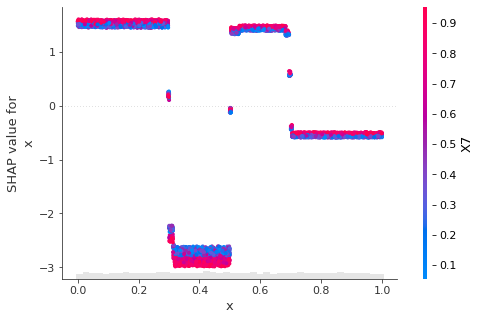

In [15]:
# Partial Dependence Plot of how x acts on selected expectile 
lightgbmlss.expectile_plot(lightgbmlss_model, 
                           X_train, 
                           dist=distribution,
                           expectile="0.05",
                           feature="x", 
                           plot_type="Partial_Dependence")

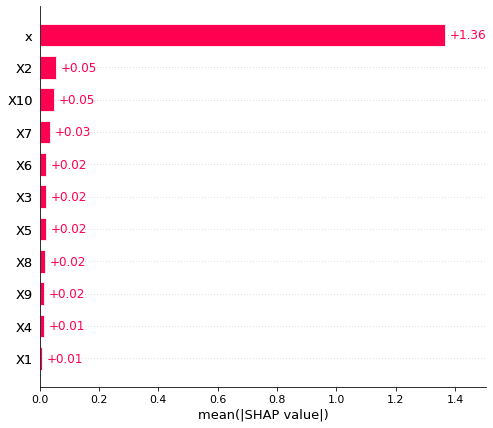

In [16]:
# Global Feature Importance of selected expectile 
lightgbmlss.expectile_plot(lightgbmlss_model, 
                           X_train, 
                           dist=distribution,
                           expectile="0.95",
                           feature="x", 
                           plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Expectiles

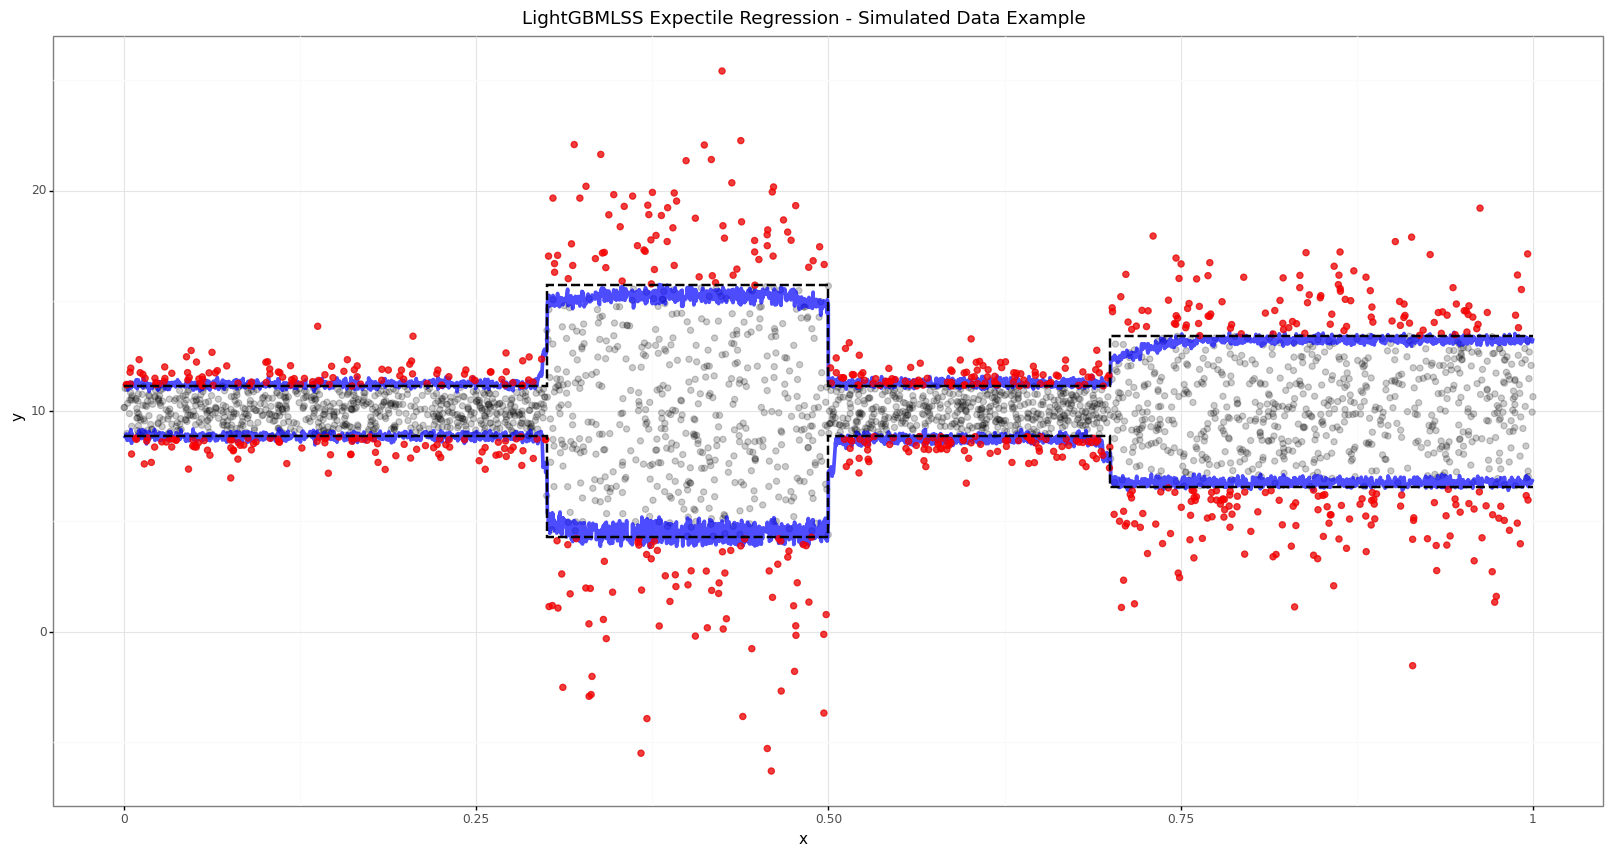

<ggplot: (134142782778)>

In [17]:
np.random.seed(123)

###
# Actual Expectiles
###
y_loc = np.array([10])
y_scale = np.array([1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7)])
tau_lower = np.array([distribution.expectiles[0]])
tau_upper = np.array([distribution.expectiles[1]])

# Calculates exact expectiles assuming a Normal distribution
expectile_lb = Expectile.expect_norm(tau_lower,
                                     m=y_loc,
                                     sd=y_scale).reshape(-1,)

# Calculates exact expectiles assuming a Normal distribution
expectile_ub =  Expectile.expect_norm(tau_upper,
                                      m=y_loc,
                                      sd=y_scale).reshape(-1,)

test["expect"] = np.where(test["y"].values < expectile_lb, 0, np.where(test["y"].values < expectile_ub, 1, 2))
test["alpha"] = np.where(test["y"].values <= expectile_lb, 1, np.where(test["y"].values >= expectile_ub, 1, 0))
df_expectiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(expectile_lb))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(expectile_ub))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Expectiles
###
test["lb"] = pred_expectile.iloc[:,0]
test["ub"] = pred_expectile.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "LightGBMLSS Expectile Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1.5,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1.5,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_expectiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)